# Extract

## Table of contents
1. [What is an Extract?](#whatis)
2. [How to create an Extract?](#howto)
3. [Tips & tricks](#tricks)

## 0. Tutorial setup

In [2]:
import logging

logging.basicConfig(level=logging.INFO)

## 1. What is an Extract? <a name="whatis"></a>

Extract is a tool for migrating data between different databases.
<br>
Currently, only `S3` is supported as storage backend.

## 2. How to create an Extract? <a name="howto"></a>

You can create an extract either by 1) providing the required parameters, or 2) creating a JSON file with the definition of the extract.
1. `extract = Exctract(name=my_name, qf=my_qf, ...)`
2. `extract = Extract.from_json(json_path)`

### 2.1 Pure python

In [3]:
from grizly import QFrame, Extract, SchedulerDB

qf = QFrame(dsn="DenodoODBC", schema="te_industrial", table="grizly")
extract = Extract(
    name="Extract Tutorial",
    qf=qf,
    output_dsn="redshift_acoe",
    partition_cols=["country"],
    dask_scheduler_address="dask_scheduler:8786",
    if_exists="replace"
)

In [3]:
print(extract)

qf                                                                      SQLDriver
name                                                             Extract Tutorial
staging_schema                                                      acoe_spectrum
staging_table                                                    extract_tutorial
prod_schema                                                            data_loads
prod_table                                                                   None
output_dsn                                                          redshift_acoe
output_dialect                                                               None
output_source_name                                                           None
output_table_type                                                        external
autocast                                                                     True
s3_root_url                               s3://acoe-s3/extracts/extract_tutorial/
s3_bucket       

In [4]:
local_registry = SchedulerDB("pytest_redis")
extract.submit(registry=local_registry)

2020-11-30 12:55:04,371 - distributed.worker.extract_tutorial - INFO - Submitting job Extract Tutorial...
2020-11-30 12:55:17,280 - distributed.worker.extract_tutorial - INFO - Job Extract Tutorial finished with status success


True

### 2.2 JSON
* See [Extract store documentation](#extract_store) for more information

We are using the input `QFrame`'s store as the base for extract's store, additionally wrapping it with additional extract-specific parameters. The store if then of the structure:
```json
"extract": {
    "name": "My Extract",
    "qframe": "qframe's store here...",
    "param1": "val1",
    "param2": "val2",
    ...
}
```

The store may differ depending on the input database. For example, for Denodo extracts, the user needs to specify a list of columns that will be used for partitioning the data into multiple chunks that will be downloaded in parallel. See [Denodo Extract](#denodo_extract) for more information.

**As of 0.4.0, there is no automated way of creating an Extract store.** For now, it's best to use an existing `QFrame` store and work from there.

In [19]:
from grizly import Store
from pprint import pprint

store = Store.from_json("s3://acoe-s3/extracts/extract_tutorial/extract_tutorial.json")
pprint(store.extract)

{'dask_scheduler_address': 'dask_scheduler:8786',
 'if_exists': 'replace',
 'name': 'Extract Tutorial',
 'output_db': None,
 'output_dialect': None,
 'output_dsn': 'redshift_acoe',
 'output_table_type': None,
 'partition_cols': <BoxList: ['country']>,
 'priority': None,
 'prod_schema': None,
 'prod_table': None,
 'qframe': {'select': {'distinct': '',
                       'fields': {'billings': {'as': '',
                                               'dtype': 'DOUBLE',
                                               'expression': '',
                                               'group_by': '',
                                               'order_by': '',
                                               'select': ''},
                                  'city': {'as': '',
                                           'dtype': 'VARCHAR(200)',
                                           'expression': '',
                                           'group_by': '',
                              

In [1]:
from grizly import QFrame, Extract, SchedulerDB
from grizly.config import config

bucket = config.get_service("s3").get("bucket")

extract = Extract.from_json("s3://acoe-s3/extracts/extract_tutorial/extract_tutorial.json")
print(extract)

qf                                                                      SQLDriver
name                                                             Extract Tutorial
staging_schema                                                      acoe_spectrum
staging_table                                                    extract_tutorial
prod_schema                                                            data_loads
prod_table                                                                   None
output_dsn                                                          redshift_acoe
output_dialect                                                               None
output_source_name                                                           None
output_table_type                                                        external
autocast                                                                     True
s3_root_url                               s3://acoe-s3/extracts/extract_tutorial/
s3_bucket       

In [20]:
local_registry = SchedulerDB("pytest_redis")
extract.submit(registry=local_registry)

2020-11-30 12:45:16,811 - distributed.worker.extract_tutorial - INFO - Job Extract Tutorial successfully registered
2020-11-30 12:45:16,827 - distributed.worker.extract_tutorial - INFO - Submitting job Extract Tutorial...
2020-11-30 12:45:28,915 - distributed.worker.extract_tutorial - INFO - Job Extract Tutorial finished with status success


True

## 3. Extract types

### 3.1 Denodo <a name="denodo_extract"></a>

There are several strategies for selecting an optimal partition column. The goal is to have data split into 2-300 (depending on the size of data) more or less equal parts. One good idea is to use GROUPBYs on columns that seem like good candidates (eg. years, months). Another method utilizing a pandas DataFrame is shown below.

1. Find columns with relatively few unique values

In [2]:
df = qf.to_df()
df.nunique()

TrackId         3503
Name            3257
AlbumId          347
MediaTypeId        5
GenreId           25
Composer         852
Milliseconds    3080
Bytes           3501
UnitPrice          2
dtype: int64

2. Check the distribution of values

In [3]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, http://acoe.connect.te.com
  Using cached matplotlib-3.3.3-cp38-cp38-manylinux1_x86_64.whl (11.6 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.3.1-cp38-cp38-manylinux1_x86_64.whl (1.2 MB)


<AxesSubplot:>

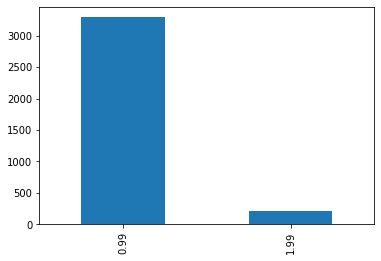

In [4]:
df.UnitPrice.value_counts().plot(kind="bar")

<AxesSubplot:>

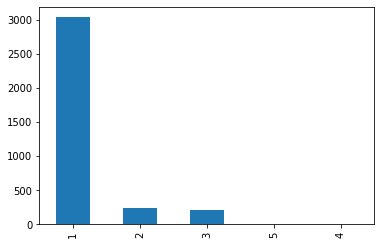

In [5]:
df.MediaTypeId.value_counts().plot(kind="bar")

<AxesSubplot:>

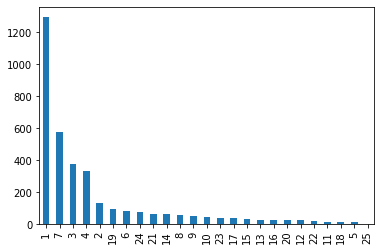

In [6]:
df.GenreId.value_counts().plot(kind="bar")        

It seems like the GenreId column has the most optimal distribution.

### 3.2 SFDC

The SFDC Extract automatically chunks data, so here we only need to pass whatever settings we need for our load. Below is a working example, extracting some sample data from the `Account` table.

In [5]:
from grizly import QFrame, Extract, SchedulerDB

qf = QFrame(dsn="sfdc", table="Account").limit(1000)
qf.remove_compound_fields()
extract = Extract(
    name="Tutorial SFDC Extract",
    qf=qf,
    output_dsn="redshift_acoe",
    dask_scheduler_address="dask_scheduler:8786"
)

print(extract)

qf                                                                     SFDCDriver
name                                                        Tutorial SFDC Extract
staging_schema                                                      acoe_spectrum
staging_table                                               tutorial_sfdc_extract
prod_schema                                                            data_loads
prod_table                                                                   None
output_dsn                                                          redshift_acoe
output_dialect                                                               None
output_source_name                                                           None
output_table_type                                                        external
autocast                                                                     True
s3_root_url                          s3://acoe-s3/extracts/tutorial_sfdc_extract/
s3_bucket       

In [6]:
local_registry = SchedulerDB("pytest_redis")
extract.submit(registry=local_registry)

2020-11-30 12:57:48,207 - distributed.worker.tutorial_sfdc_extract - INFO - Generating tasks...
2020-11-30 12:57:52,377 - distributed.worker.tutorial_sfdc_extract - INFO - Tasks generated successfully


JobAlreadyRunningError: Job Tutorial SFDC Extract is already running. Please use Job.stop() or Job.restart()

### 2.2 Create a folder for assets in S3
We'll be storing some assets on S3, so go ahead and create a folder for your extract in S3. By default, Extract will look for store in `s3://your_bucket/extracts/your_extract_name`. However you can modify this behavior by specifying the `s3_root_url` parameter, eg. to 
```python
f"s3://{my_bucket}/my/path/"
```

## 4. Tips & tricks

### 4.1 Utilizing `if_exists="append"`

The `append` parameter allows us to load only the new partitions. For example, if we are loading a table that refreshes weekly, we can provide a set of partition columns that include a week columns, eg.
```json
{
  partitions_list: ["other_col", "week_no"]
}
```
This way, whenever an Extract with the `append` option is re-run, it will not re-download the parts for existing weeks.

## 5. Extract store in depth <a name="extract_store"></a>